## First pass analysis

Looking at log-normalized Thalamus scRNA-seq data sent from Cindy van Velthoven on 5/13/22. Selected clusters with "TH" annotation.
\\allen\programs\celltypes\workgroups\mct-t200\Cindy_analysis\Projects\TH\WB_TH_subtax

In [5]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse

Need to load data + annotation, and construct AnnData object

In [3]:
# Read sparse data matrix (converted in RStudio from .rda to .mtx) ~10 min
logNormCOO = scipy.io.mmread("../Data/TH_data.mtx")

In [8]:
# Tranpose matrix to match AnnData standards (cells x genes), and convert to indexable sparsity format
logNormCOO = logNormCOO.transpose()
logNormCSR = logNormCOO.tocsr()

In [9]:
# Load annotation data
thAnno = pd.read_feather("../Data/TH_annotation.feather")
thGenes = pd.read_feather("../Data/gene_names.feather")
# Alter dataframe column name
thGenes.columns = ['gene']

In [10]:
# Construct AnnData object
thData = ad.AnnData(logNormCSR)

C:\Users\mathew.summers\AppData\Local\Temp\ipykernel_7184\2773528772.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  thData = ad.AnnData(logNormCSR)


In [11]:
# Make AnnData object indexable by assigning proper names to rows and columns
thData.obs_names = thAnno.sample_id
thData.var_names = thGenes['gene']

# Example indexing:
thData["ACGGAAGGTTCCAGGC-L8TX_200716_01_B06-1040281892"]
thData[0:5,["Xkr4"]]

View of AnnData object with n_obs × n_vars = 5 × 1

In [16]:
# View various annotation categories
thAnno.columns

Index(['sample_id', 'umi.counts', 'gene.counts', 'external_donor_name', 'age',
       'species', 'sex', 'control', 'cell_prep_type', 'full_genotype',
       'facs_population_plan', 'cre_line', 'reporter', 'roi', 'qc.score',
       'roi_label', 'region_old', 'region_label', 'region_id', 'region_color',
       'roi_id', 'roi_color', 'cl', 'cluster_id', 'cluster_label',
       'cluster_color', 'subclass_id', 'subclass_label', 'subclass_color',
       'class_id', 'class_label', 'class_color', 'forebrain_cluster_label',
       'forebrain_subclass_label', 'forebrain_neighborhood_label'],
      dtype='object')

In [98]:
# Need to copy over annotation into AnnData object
# Perhaps isn't perfect; didn't copy over every element, and some variable types may be suboptimal
thData.obs["sample_id"] = pd.Categorical(thAnno["sample_id"])
thData.obs["umi_counts"] = np.float32(thAnno["umi.counts"])
thData.obs["gene_counts"] = np.float32(thAnno["gene.counts"])
thData.obs["sex"] = pd.Categorical(thAnno["sex"])
thData.obs["qc"] = np.float32(thAnno["qc.score"])
thData.obs["facs"] = pd.Categorical(thAnno["facs_population_plan"])
thData.obs["roi"] = pd.Categorical(thAnno["roi"])
thData.obs["roi_label"] = pd.Categorical(thAnno["roi_label"])
thData.obs["roi_color"] = pd.Categorical(thAnno["roi_color"])
thData.obs["cl"] = pd.Categorical(thAnno["cl"])
thData.obs["cluster_id"] = pd.Categorical(thAnno["cluster_id"])
thData.obs["cluster_label"] = pd.Categorical(thAnno["cluster_label"])
thData.obs["cluster_color"] = pd.Categorical(thAnno["cluster_color"])
thData.obs["subclass_id"] = pd.Categorical(thAnno["subclass_id"])
thData.obs["subclass_label"] = pd.Categorical(thAnno["subclass_label"])
thData.obs["subclass_color"] = pd.Categorical(thAnno["subclass_color"])
thData.obs["class_id"] = pd.Categorical(thAnno["class_id"])
thData.obs["class_label"] = pd.Categorical(thAnno["class_label"])
thData.obs["class_color"] = pd.Categorical(thAnno["class_color"])
thData.obs["forebrain_cluster_label"] = pd.Categorical(thAnno["forebrain_cluster_label"])
thData.obs["forebrain_subclass_label"] = pd.Categorical(thAnno["forebrain_subclass_label"])
thData.obs["forebrain_neighborhood_label"] = pd.Categorical(thAnno["forebrain_neighborhood_label"])

In [80]:
# Check annotations inputs
thAnno.roi_color.unique()

0        #5E1FCC
1        #E826FF
2        #FFF873
3        #FFF873
4        #997145
          ...   
66795    #FFD126
66796    #FFD126
66797    #FFD126
66798    #FFD126
66799    #FFD126
Name: roi_color, Length: 66800, dtype: object

In [93]:
# Check annotation outputs
thData.obs.class_label.unique()

['Glut', 'NN', 'Gaba']
Categories (3, object): ['Gaba', 'Glut', 'NN']

Should consider subsetting the data for debugging computationally intensive processes. For now, pre-processing / basic analysis continues below:

In [99]:
# Compute highly variable genes (Seurat package) ~25 min
sc.pp.highly_variable_genes(thData)

In [105]:
# HVGs are added to gene metadata
thData.var

,highly_variable,means,dispersions,dispersions_norm
gene,,,,
Xkr4,False,10.302215,9.785879,-0.051772
Rp1,False,2.053432,5.698971,-0.677508
Sox17,True,1.738864,8.658688,2.414293
Mrpl15,False,4.916291,5.938955,-0.690498
Lypla1,False,0.697767,5.404463,-0.885090
...,...,...,...,...
AC168977.1,True,0.415563,6.534548,1.315086
AC149090.1,False,8.213197,7.787243,0.009655
CAAA01118383.1,False,3.959047,6.042107,-0.352345


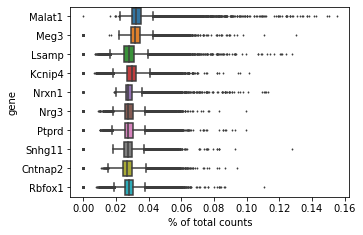

In [106]:
# Plot highly expressed genes
sc.pl.highest_expr_genes(thData, n_top=10)

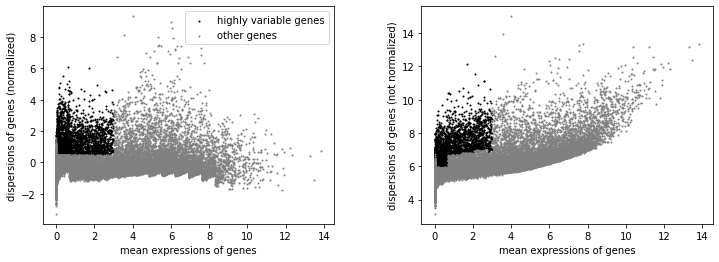

In [108]:
# Plot normalized and unnormalized highly variable genes
sc.pl.highly_variable_genes(thData)

In [120]:
# Get umap embedding. Requires computing neighborhood map, which by default uses PCA pre-process. 
# ~1 hr total, umap pretty quick.
print("Beginning embedding. Time =", current_time) # need to fix time printing
sc.pp.neighbors(thData)
print("Neighborhood complete. Time =", current_time)
sc.tl.umap(thData)
print("Finished. Time =", current_time)

Beginning embedding. Time = 14:51:15
Neighborhood complete. Time = 14:51:15
Finished. Time = 14:51:15


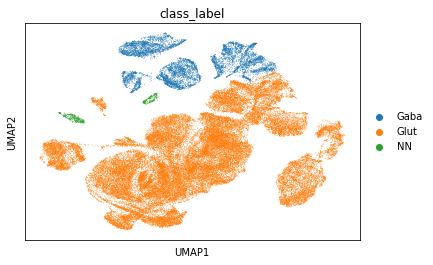

In [126]:
sc.pl.umap(thData, color="class_label")

In [127]:
# Save file ~30 min(?)
fnResults = "../Data/thData.h5ad"
thData.write(fnResults)

## Notes from pre-processing steps

Many packages suggest looking at a subset of genes to avoid weird edge effects. However this pre-processing does not account for cell type, and may eliminate presumptive marker genes (e.g. Gad1 doesn't appear in the top 2000 highly variable genes, and Slc17a6 [Vglut2] does not appear in the top 5000)

In [ ]:
# Code block to subset by top genes
sc.pp.highly_variable_genes(thData,n_top_genes=5000)
# Plot normalized and unnormalized highly variable genes
sc.pl.highly_variable_genes(thData)
thData = thData[:,thData.var["highly_variable"]]